CSW ML: to increase the similarity between human and net csw task, i should give not a single story, but multiple stories to networks. this will allow me to assess the effects of curriculum during outer loop training, and on how cell evolves state with frozen weights. These might interact. e.g. I could outer loop train interleaved, then eval inner loop with blocked. 

In [14]:
import numpy as np
from glob import glob as glob

from cswsims import *
from analysis import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [83]:
task = CSWTask()
graph = task.get_graph(1)
path = task.gen_single_path(graph)
graphid = np.random.choice([10,11])
X,Y = task.dataset_fullstory_with_marker(path,graphid)
print(X)
print('--')
print(Y)

[[[ 0]]

 [[11]]

 [[ 2]]

 [[ 4]]

 [[ 6]]]
--
[[[11]]

 [[ 2]]

 [[ 4]]

 [[ 6]]

 [[ 8]]]


## train single net

In [29]:
lstm_size = 15
net = NetGraph(lstm_size)

In [46]:
graph_pr = 0.8
trainer = Trainer(net,graph_pr)

In [47]:
int_curr = [[5000,1]]
block_curr = [[5,1000]]

In [58]:
curr = int_curr

net.reinitialize()
pred_data = trainer.main_loop(curr)
yhat_data = pred_data['yhat']

**reinitializing weights**
curriculum (5000, 1)


### depth0

In [62]:
idx2path_dict = {0:(['1','3','5']),
                 1:(['1','4','5']),
                 2:(['2','4','6']),
                 3:(['2','3','6'])}
idx2color_dict = {0:'blue',1:'green',2:'blue',3:'green'}

def plt_predictions(depth,tonode1,tonode2,curr):
  f=2
  fig,axarr = plt.subplots(2,2,figsize=(13*f,6*f),sharey=True,sharex=True); axarr=axarr.reshape(-1)
  plt.subplots_adjust(left=0.05,right=0.95,wspace=0.05,hspace=0.1)
  # plotting
  for path_num,ax in enumerate(axarr):
    pathstr = idx2path_dict[path_num]
    pathstr = "-".join(pathstr[:depth+1])
    ax.plot(yhat_data[:,path_num,depth,0,tonode1],label=tonode1,c='purple',lw=3)
    ax.plot(yhat_data[:,path_num,depth,0,tonode2],label=tonode2,c='orange',lw=3)
    ax.set_title("eval input: %s"%(pathstr),size=30,color=idx2color_dict[path_num])
    plt_block_divides(ax,curr)
    ax.legend(fontsize=20,loc=2)
  # extras
  ax.set_ylim(0,1)
  ax.set_xlim(0)
  
  plt_block_divides(axarr[0],curr)
  # saving and title
  title ='LSTM_%i-curr_%s-depth_%i'%(lstm_size,curr_int2str(curr),depth)
  plt.suptitle(title,size=30)
  plt.savefig('figures/fullstory_8020/'+title)
  

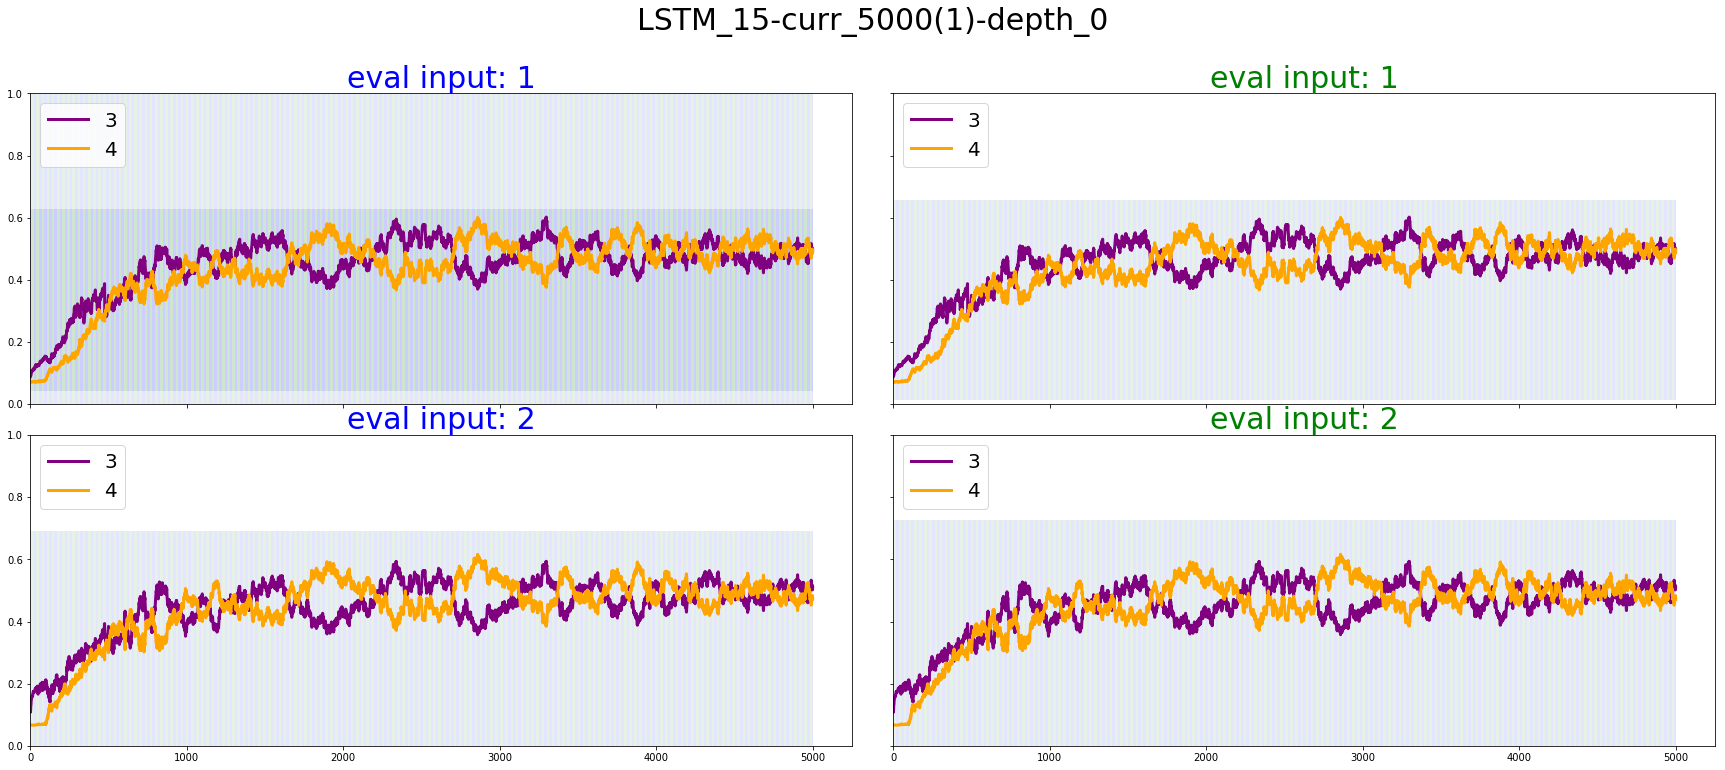

In [63]:
plt_predictions(depth=0,tonode1=3,tonode2=4,curr=curr)

(epochs,path,depth,len,num_classes)[softmax]

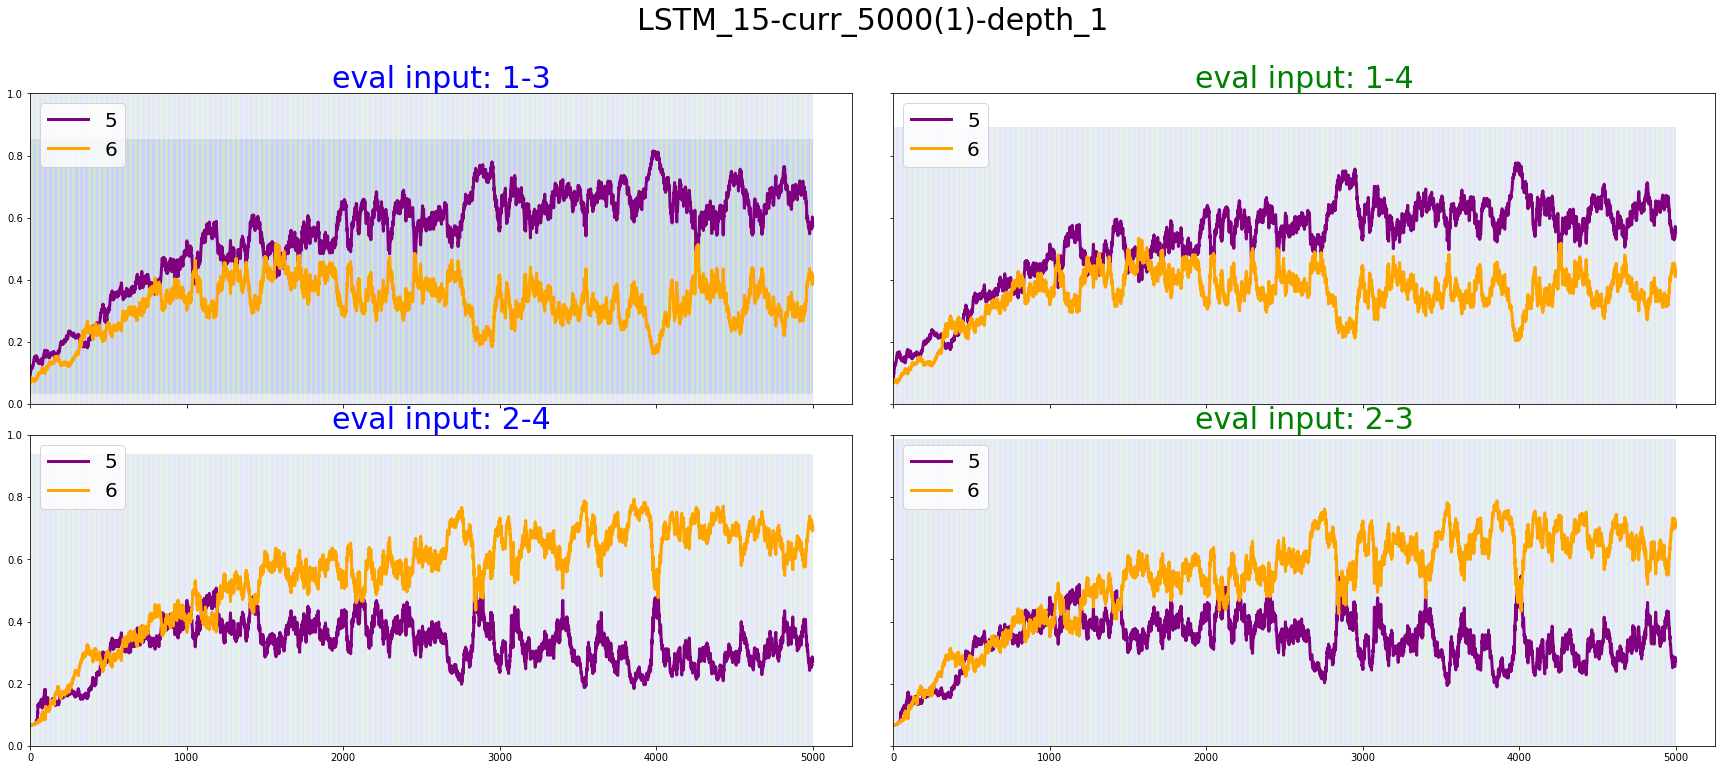

In [61]:
plt_predictions(depth=1,tonode1=5,tonode2=6,curr=curr)

## loop train and save data

In [2]:
blocked_curr = [[6,1000]]
intrlv_curr = [[5000,1],[1,1000]]

# setup
for rnn_size in [5,15,50,100]:
  print('s',rnn_size)
  net = NetGraph(rnn_size)
  trainer = Trainer(net)
  for curriculum in [blocked_curr,intrlv_curr]:
    print('c',curriculum)
    # training
    net.reinitialize()
    pred_data = trainer.main_loop(curriculum)
    # saving
    fname = 'LSTM(%i)_detcsw-curr_%s'%(rnn_size,curr_int2str(curriculum))
#     np.save('eval_data/'+fname,pred_data)

s 5
c [[6, 1000]]
**reinitializing weights**
curriculum (6, 1000)
c [[5000, 1], [1, 1000]]
**reinitializing weights**
curriculum (5000, 1)
curriculum (1, 1000)
s 15
c [[6, 1000]]
**reinitializing weights**
curriculum (6, 1000)
c [[5000, 1], [1, 1000]]
**reinitializing weights**
curriculum (5000, 1)
curriculum (1, 1000)
s 50
c [[6, 1000]]
**reinitializing weights**
curriculum (6, 1000)
c [[5000, 1], [1, 1000]]
**reinitializing weights**
curriculum (5000, 1)
curriculum (1, 1000)
s 100
c [[6, 1000]]
**reinitializing weights**
curriculum (6, 1000)
c [[5000, 1], [1, 1000]]
**reinitializing weights**
curriculum (5000, 1)
curriculum (1, 1000)


# restore and plot

In [8]:
# plotting helpers
def curr_int2str(curr):
  """
  takes an int curriculum: 
    e.g. [[5000,1],[1,1000]]
    [nblocks,epb]
  returns a str curriculum:
    e.g. "5000(1)1(1000)"
    nblocks(epb)
  """
  curstr = ""
  for nb,epb in curr: curstr += "%i(%i)"%(nb,epb) 
  return curstr

def curr_str2int(curr_str):
  """ 
  takes a string formated curriculum: 
    e.g. "5000(1)1(1000)"
  and returns a curriculum: 
    e.g. [[5000,1],[1,1000]]
  """
  curr = []
  for cu in curr_str.split(')')[:-1]:
    curr.append([int(c) for c in cu.split('(')])
  return curr
  
  
def get_block_idx(num_blocks,block_len,offset=0):
  """ 
  helper for plotting curriculum structure 
  returns the begin and end indices of blocks
  """
  start_idx_L,end_idx_L = [],[]
  for block in range(num_blocks):
    start_idx = block*block_len + offset
    end_idx = start_idx + block_len 
    start_idx_L.append(start_idx)
    end_idx_L.append(end_idx)
  return start_idx_L,end_idx_L

def plt_block_divides(ax,curr):
  """
  plotting curriculum structure (background color)
  """
  offset = 0
  startL,endL = [],[]
  for nb,epb in curr:
    start_L,end_L = get_block_idx(nb,epb,offset)
    offset = end_L[-1]
    startL.extend(start_L)
    endL.extend(end_L)
  y0,y1 = ax.get_ylim()
  colors = ['blue','green']
  for block in range(len(startL)):
    ax.fill_between([startL[block],endL[block]],y0,y1,
                      facecolor=colors[block%2],alpha=0.1)
    if len(startL)<100:
      ax.axvline(startL[block],c='r',alpha=0.1)


In [12]:
def plt_avgnode_yhat(pred_data_fpath):
  """ 
  main plotting function
  """
  # extract info from fpath (model size and curriculum structure)
  splitfpath = [f.split('_') for f in fpath.split('/')[-1].split('-')]
  size = int(splitfpath[0][0].split(')')[0].split('(')[1])
  curr_str = splitfpath[1][1].split('.')[0]
  curr = curr_str2int(curr_str)
  # load and process data
  yhat_data = np.load(fpath)['yhat']
  mean_data = avg_over_nodes(yhat_data)
  ## plot
  z=1
  fig,axarr = plt.subplots(2,1,figsize=(11*z,5*z),sharex=True); axarr=axarr.reshape(-1)
  for graph_id,ax in enumerate(axarr):
    # plot mean data
    ax.plot(mean_data[graph_id,:,0],c='g',label='optA')
    ax.plot(mean_data[graph_id,:,1],c='b',label='optB')
    ax.plot(mean_data[graph_id,:,2],c='r',label='other')
    # axes
    ax.axhline(0.2,ls='--',c='black',alpha=0.3)
    ax.axhline(0.8,ls='--',c='black',alpha=0.3)
    ax.set_ylim(0,1)
    # background shading
    plt_block_divides(ax,curr)
  # labels
  axarr[0].set_ylabel('eval context A')
  axarr[1].set_ylabel('eval context B')
  axarr[0].set_title('LSTM(%s)'%size)
  axarr[1].legend(loc=(1.003,1.8))
  save_fpath = "LSTM(%i)_det-%s"%(size,curr_str)
  plt.savefig('figures/'+save_fpath)


eval_data/LSTM(5)_detcsw-curr_6(1000).npy
eval_data/LSTM(100)_detcsw-curr_6(1000).npy
eval_data/LSTM(15)_detcsw-curr_6(1000).npy
eval_data/LSTM(5)_detcsw-curr_5000(1)1(1000).npy
eval_data/LSTM(50)_detcsw-curr_6(1000).npy
eval_data/LSTM(100)_detcsw-curr_5000(1)1(1000).npy
eval_data/LSTM(15)_detcsw-curr_5000(1)1(1000).npy
eval_data/LSTM(50)_detcsw-curr_5000(1)1(1000).npy


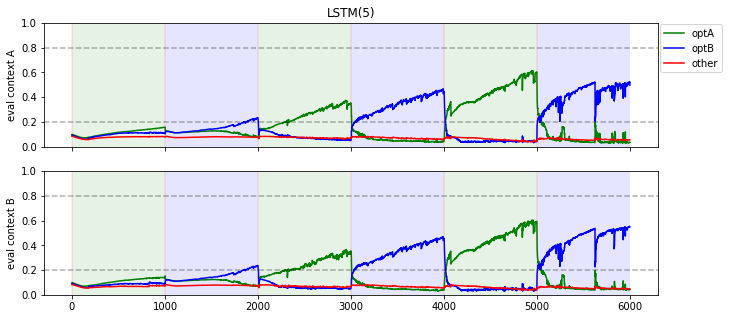

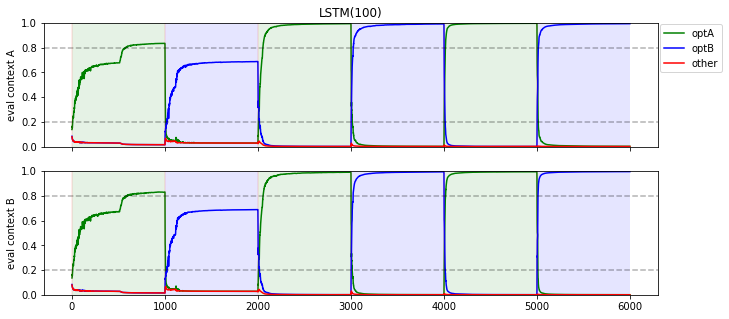

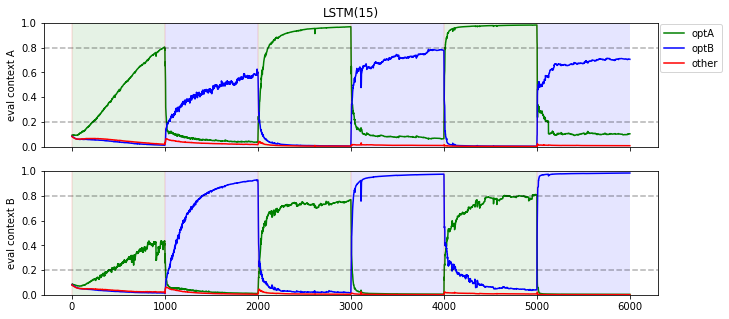

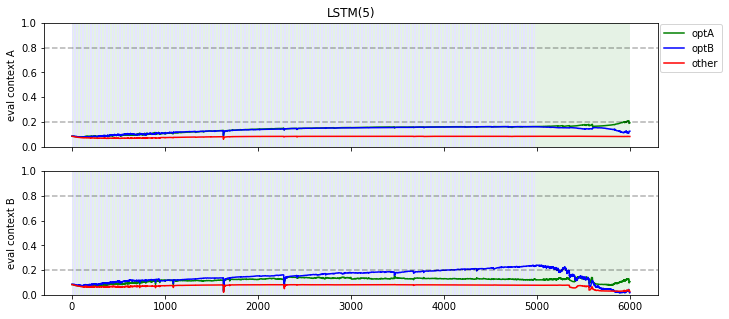

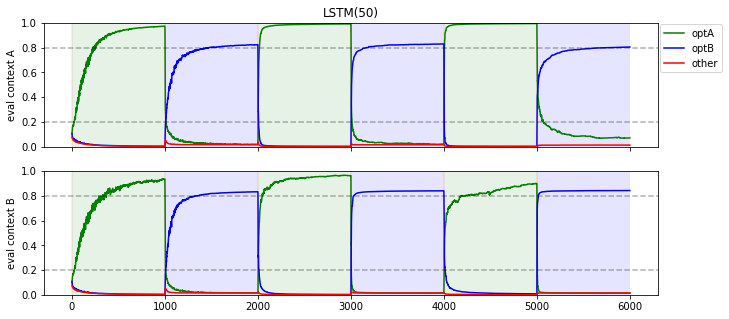

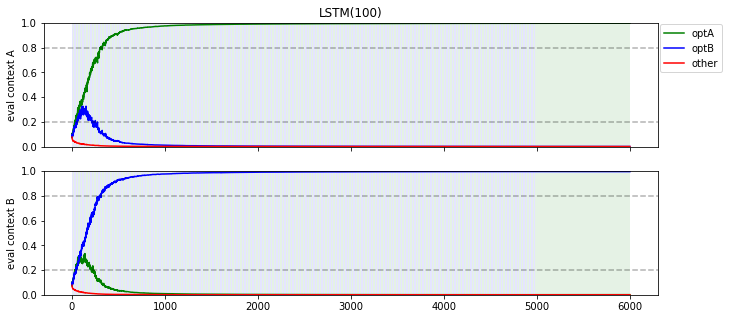

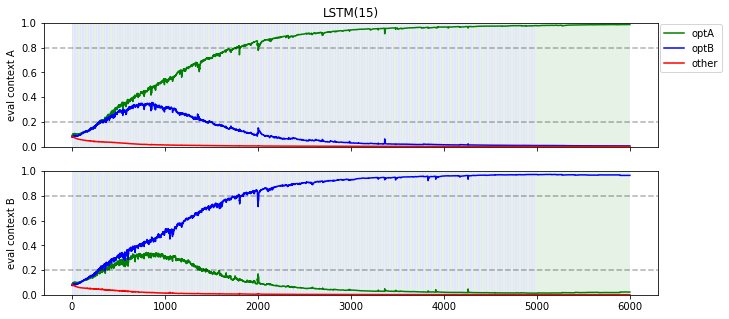

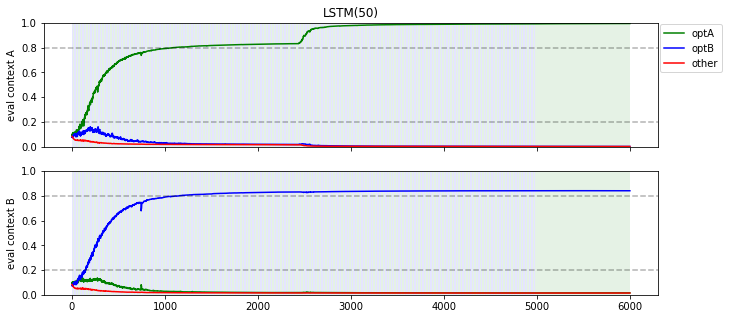

In [12]:
for fpath in glob('eval_data/LSTM(*)_det*'):
  print(fpath)
  plt_avgnode_yhat(fpath)